<a href="https://colab.research.google.com/github/vjacobsen/Liquor-Sales-Inventory-Forecast/blob/main/Liquor_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

### Provide credentials to the runtime
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

## Optional: Enable data table display
%load_ext google.colab.data_table

Authenticated


## BigCoud Query

In [ ]:
# Set up BigQuery client
project_id = 'iowa-liquor-sales-266301'

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

In [ ]:
sales_data = client.query('''

  SELECT 
    date, 
    item_number,
    item_description,
    vendor_number, 
    category_name, 
    SUM(sale_dollars) as sales_amount, 
    SUM(bottles_sold) as sales_bottles,
    CAST(EXTRACT(YEAR FROM date) as string) as year,
    CAST(EXTRACT(WEEK FROM date) as string) as week,
    CAST(EXTRACT(MONTH FROM date) as string) as month 

  FROM `bigquery-public-data.iowa_liquor_sales.sales`

  WHERE 
    date > DATE_SUB(
      (SELECT MAX(date) FROM `bigquery-public-data.iowa_liquor_sales.sales`), INTERVAL 4 YEAR)  
    AND vendor_number = '421'

  GROUP BY
    date, 
    item_number,
    vendor_number, 
    category_name, 
    item_description

''').to_dataframe()

sales_data.sample(5)

,date,item_number,item_description,vendor_number,category_name,sales_amount,sales_bottles,year,week,month
87423,2020-12-30,35213,Sobieski,421,Imported Vodkas,197.88,12,2020,52,12
82095,2019-12-09,86916,Southern Comfort 100prf,421,Whiskey Liqueur,200.53,11,2019,49,12
39571,2017-06-13,88766,Tortilla White Tequila,421,Mixto Tequila,18.60,2,2017,24,6
77582,2019-11-22,10006,Scoresby Rare Scotch,421,Scotch Whiskies,15.40,2,2019,46,11
29329,2018-05-10,69631,Dr. Mcgillicuddy's Cherry Mini,421,Imported Schnapps,127.50,17,2018,18,5


## Data Preprocessing

In [ ]:
# Rename columns
sales_data = sales_data.rename(columns={'sales_amount':'sales_dollars'})

# Create forecast key
sales_data['forecast_key'] = sales_data['item_number']

# Convert date to date
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Number of unique keys
print("Number of items:", len(sales_data['item_number'].unique()))

mapping_table = sales_data.drop_duplicates('forecast_key')[['item_number',
                                                            'category_name',
                                                            'item_description',
                                                            'forecast_key',
                                                            'vendor_number']].set_index('forecast_key')
mapping_table.head(5)

Number of items: 367


,item_number,category_name,item_description,vendor_number
forecast_key,,,,
77487,77487,Imported Distilled Spirit Specialty,Tortilla Gold Dss,421
86637,86637,Triple Sec,Tortilla Triple Sec,421
903122,903122,Special Order Items,Wiser's 18 Year Old,421
27100,27100,Straight Rye Whiskies,Sazerac Rye,421
67586,67586,Coffee Liqueurs,Kapali Coffee Liqueur,421


### Expand missing dates 



In [ ]:
from IPython.display import clear_output

# Create continuous date range for forecasts
def date_populator(df):
  first_date = df['date'].min()
  current_dates = pd.date_range(first_date, last_date)
  current_dates = pd.DataFrame(current_dates)
  current_dates['type'] = 'historical'
  current_dates = current_dates.rename(columns={0:'date'})
  df = df.merge(current_dates, on='date',how='right')

  return df

last_date = sales_data['date'].max()
print(last_date)

sales_data = sales_data.groupby('forecast_key').apply(date_populator)

sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data = sales_data.drop(columns=['forecast_key'])
sales_data = sales_data.reset_index()

# year_week key
sales_data['year_week'] = (sales_data['date'].dt.year.astype(str) + "_" + sales_data['date'].dt.isocalendar().week.astype(str))

2020-12-31 00:00:00


In [ ]:
# Drop last week and first week (might have incomplete data)
latest_week = sales_data[sales_data['date']==sales_data['date'].max()]['year_week'].values[0]
earliest_week = sales_data[sales_data['date']==sales_data['date'].min()]['year_week'].values[0]
print(earliest_week,latest_week)

sales_data = sales_data[((sales_data['year_week']!=earliest_week) & 
                         (sales_data['year_week']!=latest_week)
                         )].copy()

# Fill NA values with 0 
sales_data['sales_bottles'] = sales_data['sales_bottles'].fillna(0)

sales_data.head()

2017_1 2020_53


,forecast_key,level_1,date,item_number,item_description,vendor_number,category_name,sales_dollars,sales_bottles,year,week,month,type,year_week
0,100015,0,2017-08-25,100015,Fireball Bag in Box,421,None,270.0,6.0,2017,34,8,historical,2017_34
1,100015,1,2017-08-26,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,historical,2017_34
2,100015,2,2017-08-27,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,historical,2017_34
3,100015,3,2017-08-28,100015,Fireball Bag in Box,421,None,990.0,22.0,2017,35,8,historical,2017_35
4,100015,4,2017-08-29,100015,Fireball Bag in Box,421,None,450.0,10.0,2017,35,8,historical,2017_35


### Generate future data to forecast

In [ ]:
# Create date range for forecasts, 12 months forward looking

weeks_to_forecast = 52

last_date = sales_data['date'].max()
print(last_date)

forecast_future_dates = pd.date_range(last_date, 
                                      last_date + np.timedelta64(weeks_to_forecast,'W') 
                                      )

forecast_future_dates = pd.DataFrame(forecast_future_dates)
forecast_future_dates['type'] = 'forecast'
forecast_future_dates = forecast_future_dates.rename(columns={0:'date'})
forecast_future_dates['date'] = forecast_future_dates['date'].dt.date

forecast_future_dates['merge_dates'] = 'merge'

sales_data['merge_dates'] = 'merge'
unique_keys = sales_data.drop_duplicates('forecast_key')[['merge_dates','forecast_key']]

# Add forecasts to sales data
sales_data = sales_data.append(unique_keys.merge(forecast_future_dates))

sales_data.drop(columns='merge_dates',inplace=True)

sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data.head()

2020-12-27 00:00:00


,forecast_key,level_1,date,item_number,item_description,vendor_number,category_name,sales_dollars,sales_bottles,year,week,month,type,year_week
0,100015,0.0,2017-08-25,100015,Fireball Bag in Box,421,None,270.0,6.0,2017,34,8,historical,2017_34
1,100015,1.0,2017-08-26,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,historical,2017_34
2,100015,2.0,2017-08-27,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,historical,2017_34
3,100015,3.0,2017-08-28,100015,Fireball Bag in Box,421,None,990.0,22.0,2017,35,8,historical,2017_35
4,100015,4.0,2017-08-29,100015,Fireball Bag in Box,421,None,450.0,10.0,2017,35,8,historical,2017_35


In [ ]:
sales_data.type.value_counts()

historical    347692
forecast      133955
Name: type, dtype: int64

## Feature Engineering

In [ ]:
# Variable to forecast
target_value = 'sales_bottles'

### Weeks since start of sales

In [ ]:
# Weeks since start of sales, given by "trend" column
date_column = 'date'
first_dates = sales_data.groupby('forecast_key')[date_column].min().to_dict()

sales_data['first_date'] = [first_dates.get(x) for x in sales_data['forecast_key']]

sales_data['trend']  = sales_data['date'] - sales_data['first_date'] # days difference
sales_data['trend'] = sales_data['trend']/np.timedelta64(1,'W') # convert to weeks
sales_data['trend'] = np.ceil(sales_data['trend']) # round up

# Drop uneeded columns
sales_data = sales_data[['forecast_key',target_value,'date','trend','type']]

sales_data.head()

,forecast_key,sales_bottles,date,trend,type
0,100015,6.0,2017-08-25,0.0,historical
1,100015,0.0,2017-08-26,1.0,historical
2,100015,0.0,2017-08-27,1.0,historical
3,100015,22.0,2017-08-28,1.0,historical
4,100015,10.0,2017-08-29,1.0,historical


### Date features


In [ ]:
sales_data['month'] = sales_data['date'].dt.month
sales_data['year'] = sales_data['date'].dt.year
sales_data['week'] = sales_data['date'].dt.week

sales_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,forecast_key,sales_bottles,date,trend,type,month,year,week
0,100015,6.0,2017-08-25,0.0,historical,8,2017,34
1,100015,0.0,2017-08-26,1.0,historical,8,2017,34
2,100015,0.0,2017-08-27,1.0,historical,8,2017,34
3,100015,22.0,2017-08-28,1.0,historical,8,2017,35
4,100015,10.0,2017-08-29,1.0,historical,8,2017,35


### Holidays
Holidays are an important factor that drive sales. The week before and week after holidays might also have increased demand.

In [ ]:
import holidays

# US holiday dictionary
us_holidays = holidays.UnitedStates()

# Is day a holiday?
sales_data['is_holiday'] = [date in us_holidays for date in sales_data['date']]
sales_data['is_holiday'] = sales_data['is_holiday'].astype(int)

# Is week before a holiday?
sales_data['week_before_holiday'] = [date in us_holidays for date in (sales_data['date']-np.timedelta64(1,'W'))]
sales_data['week_before_holiday'] = sales_data['week_before_holiday'].astype(int)

# Is week after a holiday?
sales_data['week_after_holiday'] = [date in us_holidays for date in (sales_data['date']+np.timedelta64(1,'W'))]
sales_data['week_after_holiday'] = sales_data['week_after_holiday'].astype(int)

# Convert int64 cols to str
sales_data = pd.concat([sales_data.select_dtypes(exclude=['int']), 
                        sales_data.select_dtypes(include=['int']).astype(str)],
                       axis=1)

sales_data.head()

,forecast_key,sales_bottles,date,trend,type,month,year,week,is_holiday,week_before_holiday,week_after_holiday
0,100015,6.0,2017-08-25,0.0,historical,8,2017,34,0,0,0
1,100015,0.0,2017-08-26,1.0,historical,8,2017,34,0,0,0
2,100015,0.0,2017-08-27,1.0,historical,8,2017,34,0,0,0
3,100015,22.0,2017-08-28,1.0,historical,8,2017,35,0,0,1
4,100015,10.0,2017-08-29,1.0,historical,8,2017,35,0,0,0


### Group by week

In [ ]:
from datetime import timedelta

sales_data['week_end_date'] = [(x + timedelta(6-x.weekday())).date() for x in sales_data['date']]

# Group by week 
target_field_sum = sales_data.groupby(['forecast_key','week_end_date'])[target_value].sum()
features_max = sales_data.groupby(['forecast_key','week_end_date']).max().drop(columns=[target_value])
processed_dataset = features_max.join(target_field_sum).reset_index()       
processed_dataset.head()

,forecast_key,week_end_date,date,trend,type,month,year,week,is_holiday,week_before_holiday,week_after_holiday,sales_bottles
0,100015,2017-08-27,2017-08-27,1.0,historical,8,2017,34,0,0,0,6.0
1,100015,2017-09-03,2017-09-03,2.0,historical,9,2017,35,0,0,1,94.0
2,100015,2017-09-10,2017-09-10,3.0,historical,9,2017,36,1,0,0,50.0
3,100015,2017-09-17,2017-09-17,4.0,historical,9,2017,37,0,1,0,65.0
4,100015,2017-09-24,2017-09-24,5.0,historical,9,2017,38,0,0,0,40.0


## Item Segmentation
Intermittent, discontinued, new or normal. Two rules used:


If sales in the last 3 months are 0, product is discontinued

If % of weeks with 0 demand over total weeks is greater than 1.32, sales are intermittent. 
The average inter demand interval (ADI) is given by calculating 


> $Average \ Inter-demand \ Interval = \frac{Periods \ Active}{Number \ of \ Periods \ with \ Sales}$





In [ ]:
from tqdm import tqdm
tqdm.pandas()

predicted_var = target_value

zero_sales_periods_cutoff = 12 # weeks of zero sales to classify discontinued

def series_classifier(key_group):
  key_group = key_group[key_group['type']=='historical'] # only historical data

  # Average Demand Interval
  zero_sales_weeks = key_group[key_group[predicted_var]==0][predicted_var].count()
  total_weeks = key_group[predicted_var].count() 
  adi = total_weeks/(total_weeks - zero_sales_weeks) # average demand interval

  # Inttermittence
  date_cutoff = key_group['date'].max() - pd.Timedelta(zero_sales_periods_cutoff,unit='w')
  last_12_weeks_df = key_group[key_group['date'] > date_cutoff]
  last_12_weeks_sales = last_12_weeks_df[predicted_var].sum() 

  # Classify key
  if last_12_weeks_sales==0:
    return "discontinued"
  elif adi>1.32:
    return "intermittent"
  elif len(key_group)<52:
    return "new"
  else:
    return "normal"

classified_keys = processed_dataset.groupby('forecast_key').apply(series_classifier)
classified_keys.name = "key_class"

processed_dataset = processed_dataset.merge(classified_keys,
                                            how='left',
                                            left_on='forecast_key',
                                            right_index=True)

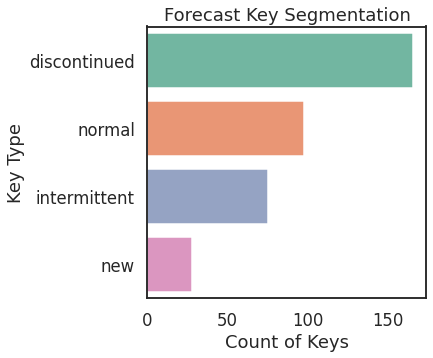

In [ ]:
sns.set(style="white")
sns.set_context("talk")
sns.set_palette("Set2")

f, ax = plt.subplots(figsize=(5, 5))

plot_df = classified_keys.value_counts().to_frame()

sns.barplot(x=plot_df['key_class'],y=plot_df.index,)

ax.set(xlabel='Count of Keys', ylabel='Key Type')
plt.title("Forecast Key Segmentation")
plt.show()

In [ ]:
# Subset keys to disco and intermittent only
processed_dataset = processed_dataset[processed_dataset['key_class']!='discontinued']

# Forecasting

## Data set up

In [ ]:
# Identify date columns
date_column = 'date'

# Select features to include in model run. Can also include "month"
features = ['month',
            'is_holiday', 
            'week_before_holiday', 
            'week_after_holiday', 
            'trend']

#target variable to be predicted
predicted_var = [target_value]

#staging variables to subset dataset to features
y_cols = predicted_var + ['type']
x_cols = features + ['type']

## SciKit Machine Learning

In [ ]:
# Import
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet, ElasticNetCV, RANSACRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, PowerTransformer, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer,make_column_selector,TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn import linear_model, metrics
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from datetime import datetime, timedelta, date

from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import uniform, randint
import statsmodels.api as sm
from pylab import rcParams

import math
import warnings
from IPython.display import clear_output
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Machine Learning Models and Pipelines

In [ ]:
### Pipelines

# For ElasticNet, we'll one hot encode data. For XGBoost we only need to label encode.
# ElasticNet will need to have interaction features created
# Pipelines for different types are created and then combined into a column transformer that will feed into final pipeline

# Feature transformers
numeric_transformer = Pipeline([('scaler',StandardScaler())
                                #('interactions',PolynomialFeatures(interaction_only=True))
                                ])

categorical_transformer = Pipeline([('onehot',OneHotEncoder(handle_unknown='ignore'))])

# Preprocessor
preprocessor = make_column_transformer((numeric_transformer, make_column_selector(dtype_exclude='object')),
                                       (categorical_transformer, make_column_selector(dtype_include='object')),
                                       sparse_threshold=0)

# XGBoost Pipeline
pipe_xgboost = Pipeline([('xgb', xgb.XGBRegressor(objective="reg:squarederror"))])

# ElasticNet Pipeline
pipe_elasticnet = Pipeline([('elnt', ElasticNet())])

# Target Transformed XGBoost Pipeline
tt = TransformedTargetRegressor(regressor=xgb.XGBRegressor(objective="reg:squarederror"), 
                                transformer=PowerTransformer(standardize=False))
pipe_xgb_transf = Pipeline([('xgb_tt', tt)])

# KNN Regressor Pipeline
pipe_knn = Pipeline([('knn',KNeighborsRegressor())])


# Parameters

# XGBoost Parameters
xgb_params = {"xgb__colsample_bytree": uniform(0.7, 0.3),
          "xgb__gamma": uniform(0, 0.5),
          "xgb__learning_rate": uniform(0.003, 0.3), # default 0.1 
          "xgb__max_depth": randint(2, 3), # default 3
          "xgb__n_estimators": randint(100, 250), # default 100
          "xgb__subsample": uniform(0.6, 0.4)}

# Target Transformed XGBoost Parameters
xgb_tt_params = {"xgb_tt__regressor__colsample_bytree": uniform(0.7, 0.3),
          "xgb_tt__regressor__gamma": uniform(0, 0.5),
          "xgb_tt__regressor__learning_rate": uniform(0.003, 0.3), # default 0.1 
          "xgb_tt__regressor__max_depth": randint(2, 3), # default 3
          "xgb_tt__regressor__n_estimators": randint(100, 250), # default 100
          "xgb_tt__regressor__subsample": uniform(0.6, 0.4)}

fit_params = {}#{'early_stopping_rounds':5}

# ElasticNet Parameters
elnt_l1_params = [.1, .5, .7, .9, .95, .99, 1]
elnt_alphas_params = [0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.]
elnt_params = [{'elnt__l1_ratio':elnt_l1_params,'elnt__alpha':elnt_alphas_params}]

# KNN Parameters
n_neighbors = [2,3,4,5]
knn_params = [{'knn__n_neighbors':n_neighbors}]


# Hyperparameter search pipes

jobs=-1

time_split = TimeSeriesSplit(n_splits = 3)

# XGB
rs_xgb =  RandomizedSearchCV(estimator=pipe_xgboost, 
                             param_distributions=xgb_params,
                             random_state=42, 
                             n_iter=4, 
                             cv=time_split, 
                             n_jobs=jobs, 
                             return_train_score=True,
                             scoring='neg_mean_squared_error')
# XGB Target Transformed
rs_xgb_tt =  RandomizedSearchCV(estimator=pipe_xgb_transf, 
                             param_distributions=xgb_tt_params,
                             random_state=42, 
                             n_iter=4, 
                             cv=time_split, 
                             n_jobs=jobs, 
                             return_train_score=True,
                             scoring='neg_mean_squared_error')

# ElasticNet
gs_elnt = GridSearchCV(estimator=pipe_elasticnet,
                    param_grid=elnt_params,
                    cv=4,
                    scoring='neg_mean_squared_error',
                    n_jobs=jobs)

# KNN
gs_knn = GridSearchCV(estimator=pipe_knn,
                     param_grid=knn_params,
                     cv=4,
                     scoring='neg_mean_squared_error',
                     n_jobs=jobs)
# ElasticNet
elntcv = ElasticNetCV(cv=4, 
                      random_state=42, 
                      l1_ratio = [.1, .5, .7, .9, .95, .99, 1], 
                      alphas=[0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])

# ElasticNet
elntcv_tt = TransformedTargetRegressor(regressor=elntcv, 
                                       transformer=PowerTransformer(standardize=False,method='yeo-johnson'))


# Auxiliary lists and dictionaries for batch forecasting

# List of pipelines for iteration
cv_searchers = [elntcv, rs_xgb, gs_knn, rs_xgb, 
                elntcv, elntcv_tt,rs_xgb_tt] 

# Dictionary of pipelines and classifier types for ease of reference
cv_search_dict = {0:'ElasticNet', 1:'XGBoost', 2:'KNN',3:'XGBoost_Trended',
                  4:'ElasticNet_Trended',5:'ElntCV_tt_Trended',6:'XGB_tt_Trended'}

trended_non_trend_cutoff = 3 # this is the position of the first trended model in cv_search_dict

## Dataset prep

In [ ]:
def train_test(X, Y, tst_size=0.20, time_aligned=True):
    
    first = X.index.min()
    last = X.index.max()
    
    global trim_date
    
    # subset train and test independent and dependent variables, split sequentially on trim date
    if time_aligned == True:
        
        delta = last - first
        weeks = (delta.days)/7 + 1
        train_weeks = round((1-tst_size)*weeks)
        test_weeks = round(tst_size*weeks)
        trim_date = last - timedelta(test_weeks*7)
        
        X_train = X.loc[X.index <= trim_date]
        x_test = X.loc[X.index > trim_date]
        Y_train = Y.loc[X.index <= trim_date]
        y_test = Y.loc[X.index > trim_date]

    else:
        X_train, x_test, Y_train, y_test = train_test_split(X, Y, random_state=42, test_size=tst_size)
    
    return X_train, x_test, Y_train, y_test


def split_input_historical(X, Y): # split dataset by historical and forecasts
    
    Y = Y[Y['type'] == 'historical']
    Y = Y.drop(columns='type')
    x_forecast = X[X['type'] == 'forecast']
    X = X[X['type'] == 'historical']
    x_forecast = x_forecast.drop(columns='type')
    X = X.drop(columns='type')

    return X, Y, x_forecast


def dataset_prep(df):
    
    # separate dependent and independent variables
    Y = df[y_cols]
    X = df[x_cols]

    # split into historical and input
    X, Y, x_forecast = split_input_historical(X, Y)
     
    # train/test split
    X_train, x_test, Y_train, y_test = train_test(X, Y)
    
    return X_train, x_test, Y_train, y_test, x_forecast, X


def mape_score_2(y_pred, y_true):
    
    error = abs(y_true - y_pred)
    ape = error/y_true
    
    return round(np.average(abs(ape), weights=y_true), 2)


def isolate_trend(df,X_train,x_test,x_forecast):
    
    # Isolate trend feature
    trend_all = df['trend'].values.reshape(-1,1) # trend components for all periods
    trend_historical = df[df['type']=='historical']['trend'].values.reshape(-1,1)
    trend_X_train = X_train['trend'].values.reshape(-1,1)
    trend_x_test = x_test['trend'].values.reshape(-1,1)
    trend_x_forecast = x_forecast['trend'].values.reshape(-1,1)

    # Remove trend feature from dataset
    X_train = X_train.drop(columns='trend')
    x_test = x_test.drop(columns='trend')
    x_forecast = x_forecast.drop(columns='trend')
    all_x = df[x_cols].drop(columns=['type','trend']) 
    
    return trend_all,trend_historical,trend_X_train,trend_x_test,trend_x_forecast,X_train,x_test,x_forecast,all_x
    

def detrend(df,trend_historical,trend_X_train,trend_x_test,Y_train,y_test):
     
    all_actuals = df[df['type']=='historical'][predicted_var].values
    trend = ransac.fit(trend_historical, all_actuals)
    
    # Detrend Y Train
    Y_train = Y_train - trend.predict(trend_X_train) 
    
    # Detrend Y test
    trend_test = trend.predict(trend_x_test)
    y_test = y_test - trend_test

    return Y_train,y_test,trend,all_actuals,trend_test
    
    
def plot_trend_graph(y_true,y_pred,trend_test,y_pred_no_trend):
    
    if idx>=trended_non_trend_cutoff:
        print('Trended Model', idx)  
                      
        # Create basic plot
        df_for_trend_plot = pd.DataFrame(y_true)
        df_for_trend_plot['trended_pred'] = y_pred
        df_for_trend_plot['isolated_trend'] = trend_test
        df_for_trend_plot['detrended_pred'] = y_pred_no_trend
        df_for_trend_plot.plot(figsize=(15,5))
        
        return plt.show()


def train_test_mapper(row):
    
    if row['type']=='forecast':
        return 'forecast'
    elif row['trim_date']>=row[date_column]:
        return 'train'
    else:
        return 'test'

In [ ]:
# Create ransac regressor to model trend
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(random_state=42)

## Batch forecaster (ML) functions

In [ ]:
# This function takes in a dataframe with historical data, splits in train test, 
# runs model pipelines and outputs best forecast and mape for each forecast key

def forecast_apply(data,trended_non_trend_cutoff=3,plot_trend=False): 
    
    global y_true,y_pred, best_forecast
    
    data = data.set_index(date_column) # Make sure index is date

    # Train/Test split
    X_train, x_test, Y_train, y_test, x_forecast, X = dataset_prep(data)
    
    # Actual sales
    y_true = y_test[predicted_var].values.reshape(1,-1)[0]

    # Filter out low data availabiltiy keys
    if len(X_train)>5 and len(x_test)>5 and len(x_forecast)>2:
        
        # Get trend components for each subset and drop Trend feature
        trend_all,trend_historical,trend_X_train,trend_x_test,\
        trend_x_forecast,X_train,x_test,x_forecast,all_x = isolate_trend(data,X_train,x_test,x_forecast)

        # Processor fit
        processor_fit = preprocessor.fit(X_train) # Preprocessor is previously defined

        # Processor transform
        processor_transform = processor_fit.transform(X_train)

        X_train = (processor_fit.transform(X_train))
        x_test = (processor_fit.transform(x_test))
        x_forecast = (processor_fit.transform(x_forecast))
        all_x = (processor_fit.transform(all_x))

        # Initialize loop variables
        best_score = 10000000000
        best_model = ''

        # Loop through model dict to find best model
        for idx, searchcv in enumerate(cv_searchers):
          try:  
            # Detrend data for specific models. Order matters, trended models need to be last in cv_searchers dict
            # Fit and Detrend, we use all historical data for this to capture overall trend.

            if idx==trended_non_trend_cutoff: 
                # Detrended Y is given by subtracting Trend from Y_true   
                Y_train,y_test,trend,all_actuals,trend_test = detrend(data,trend_historical,trend_X_train,trend_x_test,Y_train,y_test)

            # Fit grid search
            searchcv.fit(X_train, Y_train)

            # Predict on test data with best params
            y_pred = searchcv.predict(x_test)
            
            # Auxiliary transformation for compatibility with models
            if len(y_pred.shape)>1:
                y_pred = y_pred.reshape(1,-1)[0]
            
            # Add trend back to prediction if model is trended
            if idx >= trended_non_trend_cutoff: 
                trend_test = trend.predict(trend_x_test).reshape(1,-1)[0]
                y_pred = y_pred + trend_test
            
            # Auxiliary transformation for compatibility with models
            if len(y_pred.shape)>1:
                y_pred = y_pred.reshape(1,-1)[0]
            
            # Calculate MAPE
            scoring = mape_score_2(y_true, y_pred)
            
            # Plot trend graph?
            if idx >= trended_non_trend_cutoff: 
                if plot_trend==True:
                    y_pred_no_trend = searchcv.predict(x_test)
                    print('Trended Model', cv_search_dict.get(idx))                
                    # Create basic plot
                    df_for_trend_plot = pd.DataFrame(y_true)
                    df_for_trend_plot['trended_pred'] = y_pred
                    df_for_trend_plot['isolated_trend'] = trend_test
                    df_for_trend_plot['detrended_pred'] = y_pred_no_trend

                    df_for_trend_plot.plot(figsize=(15,5))
                    plt.show()
            
            # Select best (lowest MAPE) model
            if scoring < best_score:
                best_score = scoring
                best_search = searchcv
                best_model = idx
                
                # Need to add trend back to predictions if trended model
                if best_model >= trended_non_trend_cutoff:
                    best_forecast = searchcv.predict(all_x) + trend.predict(trend_all).reshape(1,-1)[0]
                else:
                    best_forecast = searchcv.predict(all_x)
            
            # Set up resulting dataframe
            data['forecast'] = best_forecast
            data['mape'] = best_score
            data['best_model'] = cv_search_dict.get(best_model)
            data['trim_date'] = trim_date
          except:
            pass
        
        return_df = data[['forecast','mape','best_model','trim_date','type']]
        clear_output()
        
        return return_df

## Execute ML forecasts

In [ ]:
# Progress bar set up
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()

# Apply forecast function to each key
indv_forecast = processed_dataset.groupby(['forecast_key']).progress_apply(forecast_apply)

# Format results
indv_forecast = indv_forecast.reset_index()
indv_forecast['type'] = indv_forecast.apply(train_test_mapper,axis=1)

100%|██████████| 201/201 [03:20<00:00,  1.00it/s]


## Breakdown forecast to days

In [ ]:
# Map week number to each date_week on forecasts
year_week_map = sales_data[['forecast_key','date','week_end_date']]
indv_forecast = indv_forecast.merge(year_week_map,on=['forecast_key','date'])

# Expand forecasts from weeks to days
days = sales_data[['forecast_key','date','is_holiday','week_end_date']]

# Forecast date is actually a week end indicator date
indv_forecast = indv_forecast.rename(columns={'date':'week_date'})
indv_forecast = indv_forecast.merge(days,on=['forecast_key','week_end_date'])

# Drop duplicates
indv_forecast = indv_forecast.drop_duplicates(subset=['forecast_key','date'])

# Breakdown weekly forecast to daily
indv_forecast['day_of_week'] = indv_forecast['date'].dt.weekday

def breakdown_fcst(row):
  if row['day_of_week'] <5:
    return round(row['forecast']/5,0)
  else:
    return 0

indv_forecast['forecast'] = indv_forecast.apply(breakdown_fcst,axis=1)

In [ ]:
# Subsets: historical and forecast
historical_predictions = indv_forecast[indv_forecast['type']!='forecast']
forecasts = indv_forecast[indv_forecast['type']=='forecast'].set_index('forecast_key')

## Data report

In [ ]:
# Plots
import plotly.express as px

fig = px.line(processed_dataset.groupby(['date']).sum().reset_index(),
              x='date',
              y=target_value, 
              title='Historical Sales')
fig.show()


mape_df = indv_forecast.groupby('forecast_key').agg({'mape':'mean','forecast':sum})
print("Weighted MAPE:", np.average(mape_df['mape'],weights=mape_df['forecast']))

# Format and add attributes to tables
mape_df = mape_df.join(mapping_table)

Weighted MAPE: 0.23431155217333818


In [ ]:
# Model performance statistics
best_model_mape = indv_forecast.groupby(['best_model','forecast_key'])['mape'].median().reset_index()
best_model_mape = best_model_mape.groupby('best_model')['mape'].median()

best_model_count = indv_forecast.groupby('forecast_key')['best_model'].agg(lambda x: stats.mode(x)[0])
best_model_count = best_model_count.value_counts().to_frame()
best_model_count = best_model_count.join(best_model_mape)
best_model_count

,best_model,mape
XGBoost,52,0.955
ElasticNet_Trended,40,0.315
ElasticNet,39,0.420
XGBoost_Trended,20,0.325
KNN,11,0.410
ElntCV_tt_Trended,6,0.200
XGB_tt_Trended,1,0.540


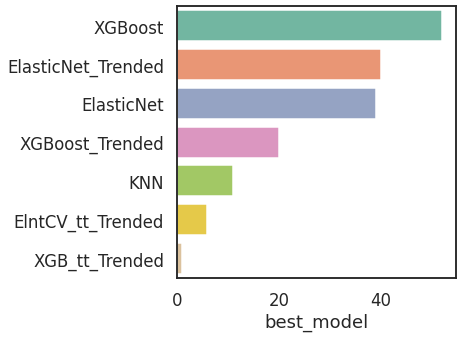

In [ ]:
fig, ax1 = plt.subplots(figsize=(5,5))

ax1 = sns.barplot(y=best_model_count.index,x='best_model',data=best_model_count)
plt.show()

# Export to BigQuery

In [ ]:
historical_sales = sales_data[['date','forecast_key',target_value]]
historical_sales = historical_sales.groupby(['forecast_key','date']).sum().reset_index()

formatted_forecasts = indv_forecast.merge(historical_sales,
                                          on=['date','forecast_key'],
                                          how='left'
                                          )

formatted_forecasts = formatted_forecasts.set_index('forecast_key').join(mapping_table)
formatted_forecasts.sample(5)

,week_date,forecast,mape,best_model,trim_date,type,week_end_date,date,is_holiday,day_of_week,sales_bottles,item_number,category_name,item_description,vendor_number
forecast_key,,,,,,,,,,,,,,,
89916,2017-06-18,12.0,0.40,ElasticNet,2020-03-15,train,2017-06-18,2017-06-14,0,2,48.0,89916,Mixto Tequila,Tortilla Gold Tequila,421
65066,2021-09-12,0.0,0.22,ElasticNet,2020-08-09,forecast,2021-09-12,2021-09-11,0,5,0.0,65066,Imported Schnapps,Goldschlager Cinnamon Schnapps,421
71886,2019-09-15,0.0,0.27,ElasticNet_Trended,2020-03-15,train,2019-09-15,2019-09-15,0,6,0.0,71886,American Cordials & Liqueur,Amaretto E Dolce,421
42167,2020-09-20,17.0,0.37,XGBoost_Trended,2020-08-09,test,2020-09-20,2020-09-16,0,2,21.0,42167,Aged Dark Rum,Myers's Original Dark Rum,421
902588,2019-03-17,-0.0,1.45,XGBoost,2020-07-12,train,2019-03-17,2019-03-13,0,2,0.0,902588,Special Order Items,Ballantine's Scotch Finest,421


In [ ]:
formatted_forecasts[target_value] =  formatted_forecasts[target_value].where(formatted_forecasts['type']!='forecast',np.nan)

In [ ]:
# Save locally
mape_df[['mape']].to_csv('mape_df.csv')
formatted_forecasts.to_csv('forecasts.csv')

### Set up project and credentials

In [ ]:
from google.cloud import bigquery

project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Construct a BigQuery client object.
client = bigquery.Client(project = project_id)

metrics_path = "/content/mape_df.csv"
forecasts_path = "/content/forecasts.csv"

file_paths = [metrics_path,forecasts_path]
table_names = ["ml_metrics","ml_forecasts"]

### Load tables to Big Query

In [ ]:
for file_path,tb_name in zip(file_paths,table_names):
  
  table_id = "{}.{}.{}".format(project_id,bq_dataset_name,tb_name)

  job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.CSV, 
      skip_leading_rows=1, 
      autodetect=True,
      
  )

  job_config.write_disposition = 'WRITE_TRUNCATE' 

  with open(file_path, "rb") as source_file:
      job = client.load_table_from_file(source_file, table_id,job_config=job_config)
      
  job.result()  # Waits for the job to complete.

  table = client.get_table(table_id)  # Make an API request.

  print(
      "Loaded {} rows and {} columns to {}".format(
          table.num_rows, len(table.schema), table_id
      )
  )

Loaded 169 rows and 2 columns to iowa-liquor-sales-266301.forecasting.ml_metrics
Loaded 246206 rows and 16 columns to iowa-liquor-sales-266301.forecasting.ml_forecasts


In [ ]:
# Need to join actual sales
historical_predictions = historical_predictions.merge(processed_dataset[['forecast_key','date',target_value,'trend']],
                                                      how='left',
                                                      on=['date','forecast_key'])

# Random key report

In [ ]:
sns.set_style('white')
sns.set_context('talk')

# Ransac regressor to extract trend
from sklearn.linear_model import RANSACRegressor,HuberRegressor, LinearRegression
ransac2 = RANSACRegressor(random_state=42)
huber = HuberRegressor()
lr = LinearRegression()

def plot_rand_key(rand=True):

  global data_actuals,trend_data
    
  key = specific_key
  if rand==True:
    key = pd.DataFrame(forecasts.index.unique()).sample().values[0][0] # get sample key

  print(key)
  
  # Get for key
  data_fcst = forecasts.loc[key].groupby('week_date').sum()
  data_actuals = historical_predictions[(historical_predictions['forecast_key']==key) & (historical_predictions['type']!='forecast')]
  historical_forecasts = formatted_forecasts.loc[key].groupby('week_date').sum()

  # Predict trendline 
  cols = ['week_date','trend'] + [predicted_var]
  
  trend_data = data_actuals.dropna()
  trend_y = trend_data[predicted_var[0]].values.reshape(-1,1)
  trend_x = trend_data['trend'].values.reshape(-1,1)
  trend_data['trend_line_huber'] = huber.fit(trend_x,trend_y).predict(trend_x)
  trend_data['trend_line_lr'] = lr.fit(trend_x,trend_y).predict(trend_x)
  
  try:
    trend_data['trend_line_ransac'] = ransac.fit(trend_x,trend_y).predict(trend_x)
  except: 
    trend_data['trend_line_ransac'] = 0
  
  trend_data['detrended_actuals'] = trend_data[predicted_var[0]] - trend_data['trend_line_ransac']
  
  # Power Transform
  trend_data['pt_actuals'] = PowerTransformer().fit_transform(trend_data['detrended_actuals'].values.reshape(-1,1))

  # Plot Time Series 
  plt.figure(figsize=(14,6))

  ### Actuals
  sns.lineplot(x="week_date", y=predicted_var[0],color="grey",linewidth=2,data=data_actuals)

  ### Trend 
  sns.lineplot(x='date', y='trend_line_ransac' ,color='orange', alpha=0.7, data=trend_data)

  ### Forecast 
  sns.lineplot(x="week_date", y='forecast',color='#42779B', alpha=1,linewidth=3, data=data_fcst)

  ### Historical predictions 
  #sns.lineplot(x="week_date", y='forecast', color='#42779B', alpha=0.7, data=historical_forecasts)

  plt.xticks(rotation=30)
  plt.title('Actuals vs Historical - {}'.format(key))
  plt.legend(labels = ['Actuals','Trend', 'Forecast'])
  plt.savefig("time_series.png")
  plt.show()

  # Histogram 
  plt.figure(figsize=(15,5))
  plt.subplot(1, 3, 1)
  sns.distplot(trend_data[predicted_var[0]],color='gray')
  plt.title('Original Sales Dist')

  plt.subplot(1, 3, 2)
  sns.distplot(trend_data['detrended_actuals'],color='purple')
  plt.title('Detrended Dist')

  plt.subplot(1, 3, 3)
  sns.distplot(trend_data['pt_actuals'],color='#42779B')
  plt.title('Detrended - Power Transformed')
  plt.tight_layout()
  plt.show()
  
  # Stationarize series plot
  fig, ax1 = plt.subplots(figsize=(12,5))
  ax1 = sns.lineplot(x="date", y=predicted_var[0],color='gray', alpha=0.6, data=trend_data)
  #ax1 = sns.lineplot(x="date", y='detrended_actuals',color='purple', alpha=0.5, data=trend_data)
  ax1.legend(['Actuals','Detrended'],loc='upper left')
  ax2 = ax1.twinx()
  ax2 = sns.lineplot(x="date", y='pt_actuals',color='#42779B', alpha=0.5, data=trend_data)
  ax2.legend(['Power Transformed'],loc='upper right')
  plt.show()

64870


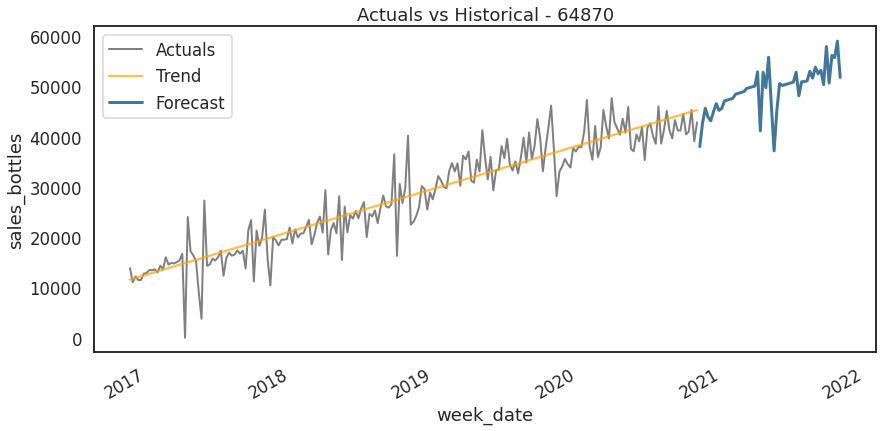

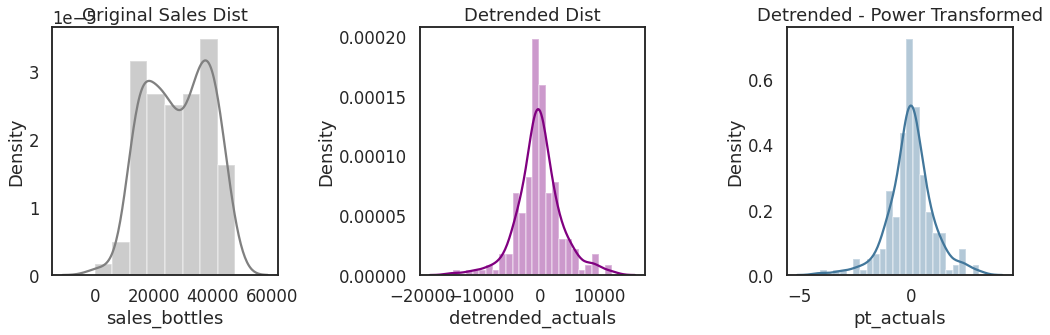

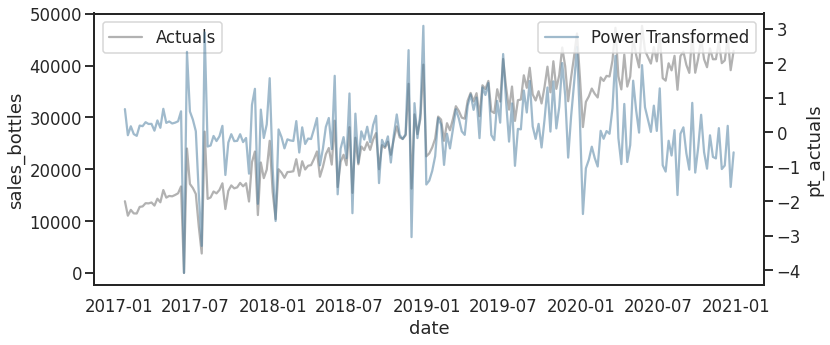

In [ ]:
#Sample key
specific_key = '64870'
plot_rand_key(rand=False)

In [ ]:
files.download("time_series.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>